In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('/content/energydata_complete.csv')
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [3]:
df.sort_values(by='date', ascending=True)
df.head


<bound method NDFrame.head of                       date  Appliances  lights  ...  Tdewpoint        rv1        rv2
0      2016-01-11 17:00:00          60      30  ...   5.300000  13.275433  13.275433
1      2016-01-11 17:10:00          60      30  ...   5.200000  18.606195  18.606195
2      2016-01-11 17:20:00          50      30  ...   5.100000  28.642668  28.642668
3      2016-01-11 17:30:00          50      40  ...   5.000000  45.410389  45.410389
4      2016-01-11 17:40:00          60      40  ...   4.900000  10.084097  10.084097
...                    ...         ...     ...  ...        ...        ...        ...
19730  2016-05-27 17:20:00         100       0  ...  13.333333  43.096812  43.096812
19731  2016-05-27 17:30:00          90       0  ...  13.300000  49.282940  49.282940
19732  2016-05-27 17:40:00         270      10  ...  13.266667  29.199117  29.199117
19733  2016-05-27 17:50:00         420      10  ...  13.233333   6.322784   6.322784
19734  2016-05-27 18:00:00         

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [5]:
df.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

Text(0.5, 1.0, 'Temperature in office room (Celsius)')

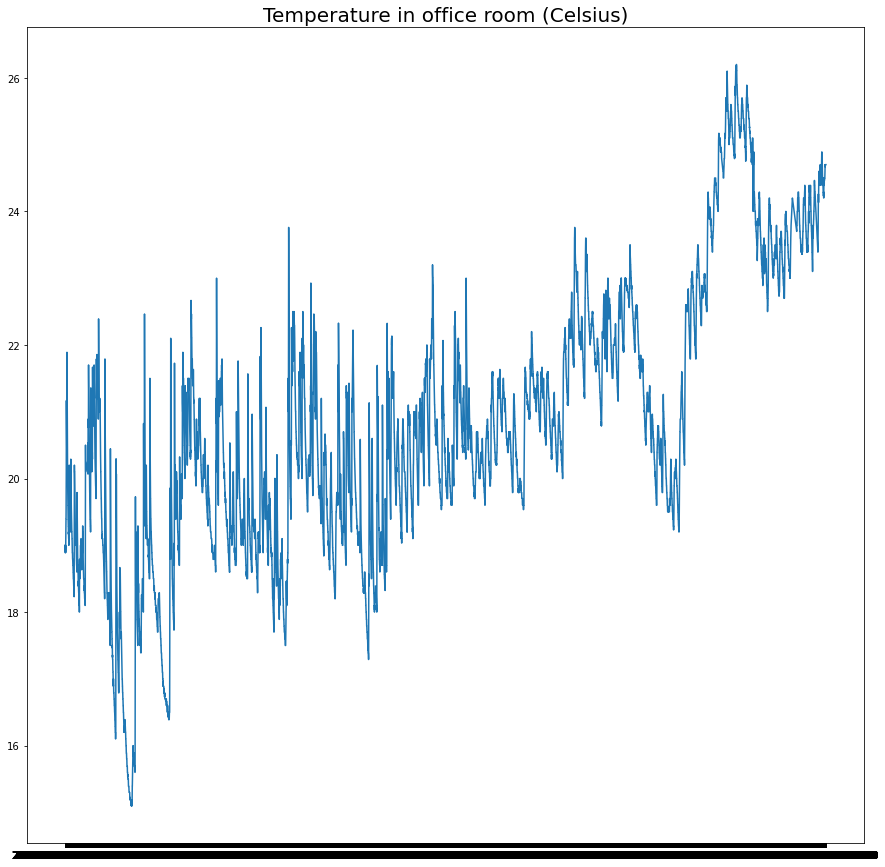

In [6]:
dates = df["date"].values
temperature_office_room = df["T4"].values

plt.figure(figsize=(15, 15))
plt.plot(dates, temperature_office_room)
plt.title(
    'Temperature in office room (Celsius)',
    fontsize=20,
)

In [7]:
X = df["T4"]
date = df["date"]

X_train, X_val, date_train, date_val = train_test_split(X, date, test_size=0.2, shuffle=False)

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [9]:
train_set = windowed_dataset(X_train.values, window_size = 60, batch_size = 100, shuffle_buffer = 1000)
val_set = windowed_dataset(X_val.values, window_size = 60, batch_size = 100, shuffle_buffer = 1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences = True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.00000e-04, momentum=0.9)

num_of_epochs = 100

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = model.fit(train_set,
                    epochs=num_of_epochs,
                    validation_data=val_set,
                    verbose=2)

Epoch 1/100
158/158 - 17s - loss: 15.1637 - mae: 15.6637 - val_loss: 9.4312 - val_mae: 9.9312
Epoch 2/100
158/158 - 6s - loss: 0.6796 - mae: 1.0670 - val_loss: 2.5577 - val_mae: 3.0489
Epoch 3/100
158/158 - 6s - loss: 0.5558 - mae: 0.9410 - val_loss: 2.5445 - val_mae: 3.0357
Epoch 4/100
158/158 - 6s - loss: 0.5440 - mae: 0.9301 - val_loss: 2.5956 - val_mae: 3.0869
Epoch 5/100
158/158 - 6s - loss: 0.5328 - mae: 0.9176 - val_loss: 2.4585 - val_mae: 2.9494
Epoch 6/100
158/158 - 6s - loss: 0.5222 - mae: 0.9054 - val_loss: 2.4930 - val_mae: 2.9840
Epoch 7/100
158/158 - 6s - loss: 0.5061 - mae: 0.8873 - val_loss: 2.4543 - val_mae: 2.9452
Epoch 8/100
158/158 - 6s - loss: 0.4755 - mae: 0.8521 - val_loss: 2.4183 - val_mae: 2.9091
Epoch 9/100
158/158 - 6s - loss: 0.4355 - mae: 0.8067 - val_loss: 2.3619 - val_mae: 2.8523
Epoch 10/100
158/158 - 6s - loss: 0.3637 - mae: 0.7169 - val_loss: 1.5194 - val_mae: 2.0068
Epoch 11/100
158/158 - 6s - loss: 0.2527 - mae: 0.5714 - val_loss: 1.0015 - val_mae: 1

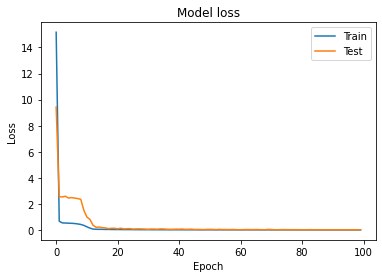

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

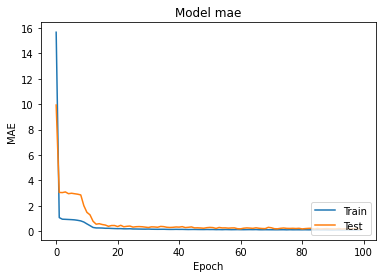

In [13]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model mae')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()